In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imageio import imread
from skimage.transform import resize
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model, Model
#from keras.models import load_model, Model

%matplotlib inline

In [2]:
image_dir_basepath = '../data/images/'
names = ['3', '29', '35'] # three type of fish (3: 鬼頭刀, 29: 赤筆, 35: 龍頭鷹哥魚)
image_size = 224

In [3]:
# load my fish ResNet-50 classifier
model_path = '../model/model-resnet50-final.h5' 
model_original = load_model(model_path)

# exclude the dense layer which outputs the class of fish
input = model_original.input
output = model_original.layers[-2].output
model = Model(input, output)
#model.summary(line_length=150)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


> How to pop out the desire layer in Keras <br>
> https://github.com/keras-team/keras/issues/2371#issuecomment-308604552
>

In [4]:
'''
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y
'''

"\ndef prewhiten(x):\n    if x.ndim == 4:\n        axis = (1, 2, 3)\n        size = x[0].size\n    elif x.ndim == 3:\n        axis = (0, 1, 2)\n        size = x.size\n    else:\n        raise ValueError('Dimension should be 3 or 4')\n\n    mean = np.mean(x, axis=axis, keepdims=True)\n    std = np.std(x, axis=axis, keepdims=True)\n    std_adj = np.maximum(std, 1.0/np.sqrt(size))\n    y = (x - mean) / std_adj\n    return y\n"

In [5]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [6]:
def load_images(filepaths):
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)
        aligned = resize(img, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
        
    return np.array(aligned_images)

In [7]:
def calc_embs(filepaths, batch_size=1):
    #aligned_images = prewhiten(load_images(filepaths))
    aligned_images = load_images(filepaths)
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))
    
    return embs

In [8]:
def train(dir_basepath, names, max_num_img=10):
    labels = []
    embs = []
    for name in names:
        dirpath = os.path.abspath(dir_basepath + name)
        filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)][:max_num_img]
        _embs = calc_embs(filepaths)
        labels.extend([name] * len(_embs))
        embs.append(_embs)
        
    embs = np.concatenate(embs)
    print('embedding dimension: ' , embs.shape)
    le = LabelEncoder().fit(labels)
    y = le.transform(labels)
    clf = SVC(kernel='linear', probability=True).fit(embs, y)
    return le, clf

In [9]:
def infer(le, clf, filepaths):
    embs = calc_embs(filepaths)
    pred = le.inverse_transform(clf.predict(embs))
    return pred

In [10]:
le, clf = train(image_dir_basepath, names)

embedding dimension:  (9, 100352)


In [11]:
test_dirpath = os.path.join(image_dir_basepath, 'Test')
test_filepaths = [os.path.join(test_dirpath, f) for f in os.listdir(test_dirpath)]

In [12]:
pred = infer(le, clf, test_filepaths)

/home/ccc/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


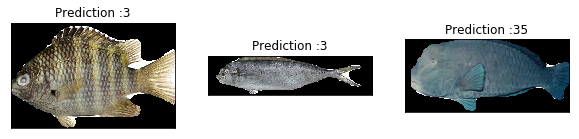

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for i in range(3):
    axes[i].set_title('Prediction :' + str(pred[i]))
    axes[i].imshow(imread(test_filepaths[i]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()